In [1]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-4.8 cpp-5 gcc-4.8-base gcc-5-base libasan0 libasan2 libgcc-4.8-dev
  libgcc-5-dev libisl15 libmpx0 libstdc++-4.8-dev libstdc++-5-dev
Suggested packages:
  gcc-4.8-locales gcc-5-locales g++-4.8-multilib gcc-4.8-doc
  libstdc++6-4.8-dbg g++-5-multilib gcc-5-doc libstdc++6-5-dbg
  gcc-4.8-multilib libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg
  libasan0-dbg libtsan0-dbg libquadmath0-dbg gcc-5-multilib libasan2-dbg
  liblsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg libstdc++-4.8-doc
  libstdc++-5-doc
The following NEW packages will be installed:
  cpp-4.8 cpp-5 g++-4.8 g++-5 gcc-4.8 gcc-4.8-base gcc-5 gcc-5-base libasan0
  libasan2 libgcc-4.8-dev libgcc-5-dev libisl15 libmpx0 libstdc++-4.8-dev
  libstdc++-5-dev
0 upgraded, 16 newly installed, 0 to remove and 12 not upgraded.
Need to get 58.3 MB of archives.
After this operati

In [2]:
!pip install torch==1.3.0

     |████████████████████████████████| 773.1MB 14kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [3]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

update-alternatives: using /usr/bin/gcc-4.8 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/gcc-5 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/g++-4.8 to provide /usr/bin/g++ (g++) in auto mode
update-alternatives: using /usr/bin/g++-5 to provide /usr/bin/g++ (g++) in auto mode


In [4]:
!git clone https://github.com/mszarski/diffsim.git

Cloning into 'diffsim'...
remote: Enumerating objects: 1202, done.
remote: Counting objects: 100% (1202/1202), done.
remote: Compressing objects: 100% (784/784), done.
remote: Total 1202 (delta 421), reused 1045 (delta 296), pack-reused 0
Receiving objects: 100% (1202/1202), 27.80 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (421/421), done.


In [5]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [6]:
%cd /content

/content


In [7]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes


Streaming output truncated to the last 5000 lines.
       ^
cc -c -O3 -Wall -fPIC -std=c99   -DMACHTYPE_ -I src/ -I build/linux/ -I external/src/   \
-DTAUCS_CORE_DCOMPLEX \
src/taucs_ccs_factor_llt.c \
-oobj/linux/taucs_ccs_factor_llt_Z.o
src/taucs_ccs_factor_llt.c: In function ‘spa_scale_add’:
src/taucs_ccs_factor_llt.c:91:14: warning: variable ‘next’ set but not used [-Wunused-but-set-variable]
   int i, ip, next;
              ^
src/taucs_ccs_factor_llt.c: In function ‘taucs_zccs_factor_llt_partial’:
src/taucs_ccs_factor_llt.c:487:7: warning: variable ‘Aj_nnz’ set but not used [-Wunused-but-set-variable]
   int Aj_nnz;
       ^
cc -c -O3 -Wall -fPIC -std=c99   -DMACHTYPE_ -I src/ -I build/linux/ -I external/src/   \
-DTAUCS_CORE_SCOMPLEX \
src/taucs_ccs_factor_llt.c \
-oobj/linux/taucs_ccs_factor_llt_C.o
src/taucs_ccs_factor_llt.c: In function ‘spa_scale_add’:
src/taucs_ccs_factor_llt.c:91:14: warning: variable ‘next’ set but not used [-Wunused-but-set-variable]
   int i, ip, next;

In [ ]:
##restart runtime here

In [1]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [3]:
%%writefile conf/draping.json
{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/2d_shape.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.3]},
        "materials": [{"data": "materials/gray-interlock.json",
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/3d_shape.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{"nodes": [302, 198, 2, 23]}],
    "gravity":[0, 0, -2],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Writing conf/draping.json


In [9]:
!rm -rf /content/default_out

In [10]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/default_out'

if not os.path.exists(out_path):
	os.mkdir(out_path)

with open('conf/draping.json','r') as f:
	config = json.load(f)

def save_config(config, file):
	with open(file,'w') as f:
		json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
scalev=1

pre_steps = 10
steps=20
epochs=5

seed_point_index = 292
handles = [302, 198, 2, 23]
flattening_line = [0,15]

def reset_sim(sim, epoch):
	if epoch < epochs:
		arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
	else:
		arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)
	
	# for node in sim.cloths[0].mesh.nodes:
	# 					node.m *= 0.01

def run_sim(steps,sim,param_v):

	loss = 0.

	print("step")
	for step in range(pre_steps + steps):
		print(step)
	
		#print(param_v[step])

		# if step > pre_steps:
		# 	for i in range(len(handles)):
		# 		sim.cloths[0].mesh.nodes[handles[i]].v -= torch.tensor([0, 0, -5.0],dtype=torch.float64) 

		if step > pre_steps:
			for i in range(len(handles)):
				sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] * spf

		# for i in range(len(handles)):
		# 	sim.cloths[0].mesh.nodes[handles[i]].v -= sim.cloths[0].mesh.nodes[handles[i]].v * 10
		# 	print(sim.cloths[0].mesh.nodes[handles[i]].v)

		# if step > pre_steps:
		# 	for i in range(len(handles)):
		# 		sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] * spf

		#for i in range(len(handles)):
		#	sim.cloths[0].mesh.nodes[handles[i]].v = torch.tensor(np.array([0.0,0.0,-10.0]), dtype=torch.float64)

		# from IPython.core.debugger import set_trace
		# set_trace()

		#sim.cloths[0].mesh.nodes[seed_point_index].v += param_v[step]

		print(sim.obstacles[0].curr_state_mesh.nodes[seed_point_index].x - sim.cloths[0].mesh.nodes[seed_point_index].x)
	  
		if step > pre_steps:
			for i in range(len(sim.cloths[0].mesh.nodes)):
				loss += torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=1) * (1 + ((step-pre_steps)/steps))

		# if step > pre_steps:
		# 	for i in range(len(sim.cloths[0].mesh.nodes)):
		# 		dist = torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=2)
		# 		loss += torch.log(dist+0.001) * (1 + ((step-pre_steps)/steps))
		
		# if step > pre_steps:
		# 	for i in [seed_point_index, *handles, *flattening_line]:
		#  		dist = torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=2)
		#  		loss += torch.log(dist+0.001) * (1 + ((step-pre_steps)/steps))

		# if step > pre_steps:
		# 	for i in [seed_point_index, *handles, *flattening_line]:
		# 		loss += torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=1) * (1 + ((step-pre_steps)/steps))
		
		arcsim.sim_step()
	
	#loss /= (len(sim.cloths[0].mesh.nodes) * steps)
	            
	avg = torch.mean(param_v,dim=1,keepdim=True)
	reg = (torch.norm(param_v-avg, dim=2)**2).mean()

	#loss = torch.norm(sim.obstacles[0].curr_state_mesh.nodes[seed_point_index].x - sim.cloths[0].mesh.nodes[seed_point_index].x, p=2)
	#reg  = torch.norm(param_v, p=2)*1000

	total_loss = loss + reg

	return total_loss

def do_train(cur_step,optimizer,sim,param_v):
	epoch = 0
	while True:
		reset_sim(sim, epoch)
		st = time.time()
		loss = run_sim(steps, sim, param_v)
		en0 = time.time()
		optimizer.zero_grad()
	
		loss.backward(retain_graph=True)

		en1 = time.time()
		print("=======================================")
		#print(param_v.data)
		#print(param_v.grad.data)
		f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
		print('epoch {}:  loss={} \n'.format(epoch, loss.data))

		print('forward time={}'.format(en0-st))
		print('backward time={}'.format(en1-en0))

		param_v.grad.data.clamp_(-10,10)

		optimizer.step()
	
		arcsim.delete_mesh(sim.cloths[0].mesh)

		if epoch>=epochs:
			break
		epoch = epoch + 1
		# break

with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
	tot_step = 1
	sim=arcsim.get_sim()
	# reset_sim(sim)

	param_v = torch.zeros([steps, 4,3],dtype=torch.float64, requires_grad=True)
	#param_v = torch.zeros([20, 3],dtype=torch.float64, requires_grad=True)

	#lr = 0.1 *1000 * 7
	lr = 0.01
	momentum = 0.4
	f.write('lr={} momentum={}\n'.format(lr,momentum))
	optimizer = torch.optim.SGD([{'params':param_v,'lr':lr}],momentum=momentum)
	# optimizer = torch.optim.Adadelta([density, stretch, bend])
	for cur_step in range(tot_step):
		do_train(cur_step,optimizer,sim,param_v)

print("done")


step
0
tensor([-0.0416, -0.0315, -0.5782], dtype=torch.float64)
1
tensor([-0.0416, -0.0315, -0.5469], dtype=torch.float64,
       grad_fn=<SubBackward0>)
2
tensor([-0.0417, -0.0314, -0.4870], dtype=torch.float64,
       grad_fn=<SubBackward0>)
3
tensor([-0.0435, -0.0314, -0.4055], dtype=torch.float64,
       grad_fn=<SubBackward0>)
4
tensor([-0.0473, -0.0302, -0.3105], dtype=torch.float64,
       grad_fn=<SubBackward0>)
5
tensor([-0.0535, -0.0311, -0.2097], dtype=torch.float64,
       grad_fn=<SubBackward0>)
6
tensor([-0.0588, -0.0312, -0.1183], dtype=torch.float64,
       grad_fn=<SubBackward0>)
7
tensor([-0.0634, -0.0363, -0.0633], dtype=torch.float64,
       grad_fn=<SubBackward0>)
8
tensor([-0.0638, -0.0361, -0.0476], dtype=torch.float64,
       grad_fn=<SubBackward0>)
9
tensor([-0.0618, -0.0345, -0.0541], dtype=torch.float64,
       grad_fn=<SubBackward0>)
10
tensor([-0.0592, -0.0323, -0.0682], dtype=torch.float64,
       grad_fn=<SubBackward0>)
11
tensor([-0.0577, -0.0317, -0.079

In [10]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [11]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/default_out/out3', '/content/default_out/out3'])
print(prof)

Overwriting visualize.py


In [12]:
!xvfb-run -s "-screen 0 1280x720x24 -ac +extension GLX +render -noreset" python visualize.py

main
4
arcsim replay /content/default_out/out3
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/default_out/out3/0000_
/content/default_out/out3/0000_rig
reply 7 
/content/default_out/out3/0000.bmp
/content/default_out/out3/0001_
/content/default_out/out3/0001_rig
/content/default_out/out3/0001.bmp
/content/default_out/out3/0002_
/content/default_out/out3/0002_rig
/content/default_out/out3/0002.bmp
/content/default_out/out3/0003_
/content/default_out/out3/0003_rig
/content/default_out/out3/0003.bmp
/content/default_out/out3/0004_
/content/default_out/out3/0004_rig
/content/default_out/out3/0004.bmp
/content/default_out/out3/0005_
/content/default_out/out3/0005_rig
/content/default_out/out3/0005.bmp
/content/default_out/out3/0006_
/content/default_out/out3/0006_rig
/content/default_out/out3/0006.bmp
/content/default_out/out3/0007_
/content/default_out/out3/0007_rig
/content/default_out/out3/0007.bmp
/content/default_out/out3/0008_
/content/default_out/out3/0008_rig
/conten

In [13]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path('/content/default_out/out3').glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    

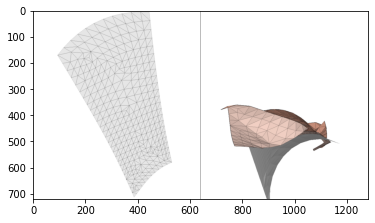

In [14]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [57]:
ani.save('diffdrape.mp4')